In [1]:
from IPython.display import display, HTML

import xlrd
import pandas as pd
import geopandas
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt

import geopandas as gp

%matplotlib inline
plt.style.use('ggplot')
mlp.rcParams['figure.figsize'] = [8.0, 8.0]

In [2]:

sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["grid.linewidth"] = 2.2
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9

In [3]:
cohortes = {
    2012: xlrd.open_workbook("../../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/cohorte 2012 consolidado y por area .xlsx"),
    2013: xlrd.open_workbook("../../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/cohorte 2013 consolidado y por area .xlsx"),
    2014: xlrd.open_workbook("../../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/cohorte 2014 consolidado y por area .xlsx"),
    2015: xlrd.open_workbook("../../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/cohorte 2015 consolidado y por areas .xlsx"),
    2016: xlrd.open_workbook("../../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/cohorte 2016 consolidado y por area .xlsx")
}

In [5]:
UglyDAS2DeptoCode = [
    (0, ['CONSOLIDADO',]),
    (9, ['XELA', 'QUETZALTENANGO']),
    (1, ['GUATE NOR OCC', 'GUATE SUR', 'GUATE SU', 'GUATEM SUR', 'GUATE NOR ORI', 
        'GUATE NOR OR', 'GUATE NOR OC', 'GUATE NOR ORIENTE', 'DAGC', 'DASGC', 
        'GUATEMALA SUR', 
        'HOSPITAL SAN VICENTE',
        'GUATEMALA CENTRAL', 'GUATEMALA NOR OCCIDENTE', 'GUATEMALA NOR ORIENTE']),
    (7, ['SOLOLA', 'SOLOL', 'SOLOLÁ']),
    (21, ['JALAPA', 'JALAP']),
    (5, ['ESCUINTLA', 'ESCUINTL']),
    (16, ['ALT VERAPAZ', 'ALTA VERAPAZ', 'ALTA VERAPA', 'ALTA VERAP']),
    (8, ['TOTO', 'TOTONICAPAN']),
    (13, ['HUEHUE', 'HUEHUETENANGO', 'HUEHUETE']),
    (6, ['SAN ROSA', 'SANTA ROSA', 'ROSA']),
    (12, ['SAN MARCOS', 'SAN MARC', 'SN MARCOS']),
    (3, ['SACATEPEQU', 'SACATEPEQUEZ', "SACATEP"]),
    (2, ['PROGRESO', 'EL PROGRESO']),
    (17, ['PET NORTE', 'PETEN NOR', 'PET SUR ORIENTAL', 'PET SUR OR','PET SUR OCC', 
         'PETEN SUR OCCID', 'PETEN SUR OCC', 'PETEN NORTE', 'PETE SUR ORIENTE',
         'PETEN SUR OR', 'PETÉN SUR OCCIDENTE', 'PETEN NORTE', 'PETEN SUR ORIENTE']),
    (22, ['JUTIAPA', 'JUTIAP']),
    (14, ['QUICHE', 'IXIL','IXCAN', 'QUICHÉ', 'IXI']),
    (20, ['CHIQUIMULA', 'CHIQUI', 'CHIQUIMULS', 'CHIGUIMULA']),
    (19, ['ZACAPA', 'ZACAP']),
    (4, ['CHIMALTENANGO', 'CHIMALTENAGO']),
    (15, ['BAJA VERAP', 'BAJA VERAPA', 'BAJA VER', 'BAJA VERAPAZ']),
    (18, ['IZABAL',]),
    (10, ['SUCHITEPEQUEZ', 'SUCHI']),
    (11, ['REU', 'REHU', 'RETALHULEU'])
]

In [122]:
# Cell types
ERROR = 5
NUMBER = 2
TEXT = 1
EMPTY = 0
MERGED = -1
MERGER = -2

# Helper functions 

def extract_table_A(sheet, row_i, extra_cols = []):
    """
        Parses a table with percentage rows, which are ignored.
        There will be many parsers because the tables are a mess
    """
    data = []
    col_offset = 0
    while sheet.cell_type(5, col_offset) == EMPTY:
        #print("Found col offset at ", sheet.name, row_i, col_offset)
        col_offset += 1
        
    if row_i>sheet.nrows:
        print("Error. Row is beyond sheet size.", sheet.name, row_i)
        return []
    cols = sheet.row_slice(row_i - 2, 2+ col_offset, 8 + col_offset) 
    while True:
        data_row = sheet.row_slice(row_i, col_offset, 8 + col_offset)
        if data_row[0].ctype == EMPTY: 
            break
        i = 0
        for val in data_row[2:7]:
            data.append( extra_cols + [data_row[0].value, cols[i].value, val.value if val.value != "" else np.NAN])
            i += 1
        row_i += 2
    return data

def process_table_A(cohortes, descriptor):
    cohorte = cohortes[descriptor["year"]]
    data = []
    for sheet in cohorte.sheets():
        code_search = list(filter(lambda item: sheet.name.strip().upper() in item[1] , UglyDAS2DeptoCode))
        if len(code_search) == 1:
            code = code_search[0][0]
        else:
            code = np.NAN
            print("Error when looking for code ", code_search, "in sheet", 
                  sheet.name, "from year", descriptor["year"])
        for table in descriptor["tables"]:
            data.extend(extract_table_A(sheet, table["row"], [descriptor["year"], table["title"], code]))
        if "values" in descriptor:
            col_offset = 0
            while sheet.cell_type(5, col_offset) == EMPTY:
                #print("Found col offset at ", sheet.name, row_i, col_offset)
                col_offset += 1

            for value in descriptor["values"]:
                if (sheet.nrows > value["row"]) & (sheet.ncols > value["col"]+col_offset-1):
                    value_ = sheet.cell_value(value["row"], value["col"]+col_offset-1)
                    data.append( [descriptor["year"], value["title"], code, "", "", value_])
                else:
                    print("Error: value out of bounds (",sheet.nrows,", ",sheet.ncols,") - ", value)
                    print("\t", (sheet.nrows <= value["row"]), (sheet.ncols <= value["col"]))
    return data

In [123]:
tablas_bk = [
    {
        "year": 2016,
        "tables": [
            { "title": "Nuevos Pulmonares BK+", "row": 204
            },
            { "title": "Nuevos Pulmonares pediatricos BK+", "row": 243
            },
            { "title": "Nuevos Pulmonares BK-", "row": 321
            },
            { "title": "Nuevos Pulmonares pediatricos BK-", "row": 339
            },
            { "title": "Nuevos Extrapulmonares BK+", "row": 285
            },
            { "title": "Nuevos Extrapulmonares pediatricos BK+", "row": 303
            },
            { "title": "Nuevos Extrapulmonares BK-", "row": 358
            },
            { "title": "Nuevos Extrapulmonares pediatricos BK-", "row": 377
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 395
            },
            { "title": "Retratamiento BK+", "row": 435
            },
            { "title": "Retratamiento Recaidas & BK+", "row": 455
            },
            { "title": "Retratamiento Abandonos Recuperados & BK+", "row": 474
            },
            { "title": "Retratamiento Fracasos & BK+", "row": 493
            },
            { "title": "Retratamiento TB/VIH & BK+", "row": 513
            },
            { "title": "Retratamiento BK-", "row": 594
            },
            { "title": "Retratamiento Recaidas & BK-", "row": 612
            },
            { "title": "Retratamiento Abandonos Recuperados & BK-", "row": 629
            },
            { "title": "Retratamiento Fracasos & BK-", "row": 646
            },
            { "title": "Retratamiento TB/VIH & BK-", "row": 664
            },
            { "title": "Retratamiento Extrapulmonar", "row": 734
            },
            { "title": "Retratamiento Extrapulmonar & TB/VIH", "row": 804
            }
        ],
        "values": [
            { "title": "MDR sensitivity tests on new", "row": 189, "col": 2 },
            { "title": "MDR confirmed cases from new", "row": 190, "col": 2 },
            { "title": "MDR test on previously treated", "row": 191, "col": 2 },
            { "title": "MDR confirmed from previously treated", "row": 192, "col": 2 },
            { "title": "MDR 2nd line treatment begun", "row": 193, "col": 2 },
            { "title": "MDR TB/HIV", "row": 194, "col": 2 },
            { "title": "MDR less than 10 years", "row": 195, "col": 2 },
            
            { "title": "RR sensitivity tests on new", "row": 189, "col": 5 },
            { "title": "RR confirmed cases from new", "row": 190, "col": 5 },
            { "title": "RR test on previously treated", "row": 191, "col": 5 },
            { "title": "RR confirmed from previously treated", "row": 192, "col": 5 },
            { "title": "RR 2nd line treatment begun", "row": 193, "col": 5 },
            { "title": "RR TB/HIV", "row": 194, "col": 5 },
            { "title": "RR less than 10 years", "row": 195, "col": 5 }
        ]
    },
    {
        "year": 2015,
        "tables": [
            { "title": "Nuevos Pulmonares BK+", "row": 176,
            },
            { "title": "Nuevos Pulmonares BK-", "row": 196
            },
            { "title": "Nuevos Extrapulmonares", "row": 213
            },
            { "title": "Nuevos Extrapulmonares TB/VIH", "row": 268
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 232
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 251
            },
            { "title": "Retratamiento BK+", "row": 287
            },
            { "title": "Retratamiento Recaidas & BK+", "row": 307
            },
            { "title": "Retratamiento Abandonos Recuperados & BK+", "row": 326
            },
            { "title": "Retratamiento Fracasos & BK+", "row": 345
            },
            { "title": "Retratamiento TB/VIH & BK+", "row": 365
            },
            { "title": "Retratamiento BK-", "row": 443
            },
            { "title": "Retratamiento Recaidas & BK-", "row": 460
            },
            { "title": "Retratamiento Abandonos Recuperados & BK-", "row": 477
            },
            { "title": "Retratamiento Fracasos & BK-", "row": 494
            },
            { "title": "Retratamiento TB/VIH & BK-", "row": 512
            },
            { "title": "Retratamiento Extrapulmonar", "row": 582
            },
            { "title": "Retratamiento Extrapulmonar & TB/VIH", "row": 652
            }
        ],
        "values": [
            { "title": "MDR sensitivity tests on new", "row": 161, "col": 2 },
            { "title": "MDR confirmed cases from new", "row": 162, "col": 2 },
            { "title": "MDR test on previously treated", "row": 163, "col": 2 },
            { "title": "MDR confirmed from previously treated", "row": 164, "col": 2 },
            { "title": "MDR 2nd line treatment begun", "row": 165, "col": 2 },
            { "title": "MDR TB/HIV", "row": 166, "col": 2 },
            { "title": "MDR less than 10 years", "row": 167, "col": 2 },
        ]
    },
        {
        "year": 2014,
        "tables": [
            { "title": "Nuevos Pulmonares BK+", "row": 172,
            },
            { "title": "Nuevos Pediatricos BK+", "row": 226
            },
            { "title": "Nuevos Pulmonares BK-", "row": 192
            },
            { "title": "Nuevos Pediatricos BK-", "row": 246
            },
            { "title": "Nuevos Extrapulmonares", "row": 209
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 281
            },
            { "title": "Nuevos Pulmonares TB/VIH BK-", "row": 300
            },
            { "title": "Nuevos Extrapulmonares Pediatricos", "row":  263
            },
            { "title": "Nuevos Extrapulmonares TB/VIH", "row":  317
            },
            { "title": "Nuevos Pediatricos TB/VIH BK+", "row":  335
            },
            { "title": "Nuevos Pediatricos TB/VIH BK-", "row":  354
            },
            { "title": "Nuevos Extrapulmonares Pediatricos TB/VIH", "row":  354
            },
            { "title": "Retratamiento BK+", "row": 389
            },
            { "title": "Retratamiento BK-", "row":  545
            },
            { "title": "Retratamiento Pediatricos BK+", "row": 825
            },
            { "title": "Retratamiento Pediatricos BK-", "row": 981
            },
            { "title": "Retratamiento Pediatricos BK+ TB/VIH", "row":  902
            },
            { "title": "Retratamiento Pediatricos BK- TB/VIH", "row": 1052 
            },
            { "title": "Retratamiento BK+ TB/VIH", "row":  467
            },
            { "title": "Retratamiento BK- TB/VIH", "row":  614
            },
            { "title": "Retratamiento Extrapulmonar", "row":  684
            },
            { "title": "Retratamiento Extrapulmonar TB/VIH", "row":  754
            },
            { "title": "Retratamiento Extrapulmonar Pediatricos", "row": 1123
            },
            { "title": "Retratamiento Extrapulmonar Pediatricos TB/VIH", "row":  1194
            }
        ],
        "values": [
            { "title": "MDR sensitivity tests on new", "row": 161, "col": 2 },
            { "title": "MDR confirmed cases from new", "row": 162, "col": 2 },
            { "title": "MDR test on previously treated", "row": 163, "col": 2 },
            { "title": "MDR confirmed from previously treated", "row": 164, "col": 2 },
            { "title": "MDR 2nd line treatment begun", "row": 165, "col": 2 },
            { "title": "MDR TB/HIV", "row": 166, "col": 2 },
            { "title": "MDR less than 10 years", "row": 167, "col": 2 },
        ]
    },
        {
        "year": 2013,
        "tables": [
            { "title": "Nuevos Pulmonares BK+", "row": 149,
            },
            { "title": "Nuevos Pediatricos", "row": 205
            },
            { "title": "Nuevos Pediatricos Extrapulmonares", "row": 257
            },
            { "title": "Nuevos Pediatricos BK+", "row": 222
            },
            { "title": "Nuevos Pulmonares BK-", "row": 169
            },
            { "title": "Nuevos Pediatricos BK-", "row": 240
            },
            { "title": "Nuevos Extrapulmonares", "row": 186
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 275
            },
            { "title": "Nuevos Pulmonares TB/VIH BK-", "row": 294
            },
            { "title": "Nuevos Extrapulmonares TB/VIH", "row":  311
            },
            { "title": "Nuevos Pediatricos TB/VIH BK+", "row":  347
            },
            { "title": "Nuevos Pediatricos TB/VIH BK-", "row":  364
            },
            { "title": "Nuevos Extrapulmonares Pediatricos TB/VIH", "row":  382
            },
            { "title": "Retratamiento BK+", "row": 399
            },
            { "title": "Retratamiento TB/VIH BK+", "row": 477
            },
            { "title": "Retratamiento BK-", "row": 555
            },
            { "title": "Retratamiento TB/VIH BK-", "row": 624
            },
            { "title": "Retratamiento Extrapulmonar", "row": 694
            },
            { "title": "Retratamiento Extrapulmonar TB/VIH", "row":  764
            },
            { "title": "Retratamiento Pediatricos", "row": 835 
            },
            { "title": "Retratamiento Pediatricos TB/VIH", "row": 904
            }
        ],
        "values": [
            { "title": "MDR sensitivity tests on new", "row": 134, "col": 2 },
            { "title": "MDR confirmed cases from new", "row": 135, "col": 2 },
            { "title": "MDR test on previously treated", "row": 136, "col": 2 },
            { "title": "MDR confirmed from previously treated", "row":137, "col": 2 },
            { "title": "MDR 2nd line treatment begun", "row": 138, "col": 2 },
            { "title": "MDR TB/HIV", "row": 139, "col": 2 },
            { "title": "MDR less than 14 years", "row": 140, "col": 2 },
        ]
    },
        {
        "year": 2012,
        "tables": [
            { "title": "Nuevos Pulmonares BK+", "row": 150
            },
            { "title": "Nuevos Pediatricos", "row": 206
            },
            { "title": "Nuevos Pediatricos Extrapulmonares", "row": 258
            },
            { "title": "Nuevos Pediatricos BK+", "row": 223
            },
            { "title": "Nuevos Pulmonares BK-", "row": 170
            },
            { "title": "Nuevos Pediatricos BK-", "row": 241
            },
            { "title": "Nuevos Extrapulmonares", "row": 187
            },
            { "title": "Nuevos Pulmonares TB/VIH BK+", "row": 276
            },
            { "title": "Nuevos Pulmonares TB/VIH BK-", "row": 295
            },
            { "title": "Nuevos Extrapulmonares TB/VIH", "row":  312
            },
            { "title": "Nuevos Pediatricos TB/VIH BK+", "row":  348
            },
            { "title": "Nuevos Pediatricos TB/VIH BK-", "row":  365
            },
            { "title": "Nuevos Extrapulmonares Pediatricos TB/VIH", "row":  383
            },
            { "title": "Retratamiento BK+", "row": 400
            },
            { "title": "Retratamiento TB/VIH BK+", "row": 478
            },
            { "title": "Retratamiento BK-", "row": 556
            },
            { "title": "Retratamiento TB/VIH BK-", "row": 625
            },
            { "title": "Retratamiento Extrapulmonar", "row": 695
            },
            { "title": "Retratamiento Extrapulmonar TB/VIH", "row":  765
            },
            { "title": "Retratamiento Pediatricos", "row": 836
            },
            { "title": "Retratamiento Pediatricos TB/VIH", "row": 905
            }
        ],
        "values": [
            { "title": "MDR sensitivity tests on new", "row": 135, "col": 2 },
            { "title": "MDR confirmed cases from new", "row": 136, "col": 2 },
            { "title": "MDR test on previously treated", "row": 137, "col": 2 },
            { "title": "MDR confirmed from previously treated", "row":138, "col": 2 },
            { "title": "MDR 2nd line treatment begun", "row": 139, "col": 2 },
            { "title": "MDR TB/HIV", "row": 140, "col": 2 },
            { "title": "MDR less than 14 years", "row": 141, "col": 2 },
        ]
    }
]

In [124]:
data = []
for descriptor in tablas_bk:
    data.extend( process_table_A(cohortes, descriptor) )

Error when looking for code  [] in sheet entregado a Paola  from year 2015
Error. Row is beyond sheet size. entregado a Paola  176
Error. Row is beyond sheet size. entregado a Paola  196
Error. Row is beyond sheet size. entregado a Paola  213
Error. Row is beyond sheet size. entregado a Paola  268
Error. Row is beyond sheet size. entregado a Paola  232
Error. Row is beyond sheet size. entregado a Paola  251
Error. Row is beyond sheet size. entregado a Paola  287
Error. Row is beyond sheet size. entregado a Paola  307
Error. Row is beyond sheet size. entregado a Paola  326
Error. Row is beyond sheet size. entregado a Paola  345
Error. Row is beyond sheet size. entregado a Paola  365
Error. Row is beyond sheet size. entregado a Paola  443
Error. Row is beyond sheet size. entregado a Paola  460
Error. Row is beyond sheet size. entregado a Paola  477
Error. Row is beyond sheet size. entregado a Paola  494
Error. Row is beyond sheet size. entregado a Paola  512
Error. Row is beyond sheet si

In [125]:
datadf = pd.DataFrame(data, columns = ["year", "table", "deptocode", "row_name", "col_name", "value"])

In [126]:
datadf.shape

(84660, 6)

In [127]:
datadf["row_name"] = datadf.row_name.map(lambda x: \
         "ABANDONO/PERDIDA_SEGM" if x in ["ABANDONOS", "PERIDA EN EL SEGUIMIENTO", "PERIDA EN EL SEGUMIENTO"]\
        else "FRACASO_TERAPEUTICO" if x in ["FRACASOS", "FRACASO TERAPEUTICO"] \
        else "TRANSFERIDOS" if x in ["TRANSFERIDOS", "TRASLADOS"] \
        else "CURADOS" if x in["CURADO", "CURADOS"] \
         else x)
datadf["col_name"] = datadf.col_name.map(lambda x: \
         "TOTAL" if x in ["TOTAL", "TOTAL TRIMESTRES"]\
         else x)

datadf["row_name_B"] = datadf.row_name.map(lambda x: \
        "LOST TO FOLLOW-UP"  if x in ["ABANDONO/PERDIDA_SEGM"]\
        else "COMPLETED TREATMENT" if x in ["FRACASO_TERAPEUTICO", "CURADOS", "TRATAMIENTOS_COMPLETOS", 
                                 "TRATAMIENTOS COMPLETOS"] \
        else "REFERRED" if x in ["TRANSFERIDOS", "TRASLADOS"] \
        else "DEATHS" if x == "FALLECIDOS" \
         else x)

datadf["value"] = datadf.value.map(lambda x: x if x!="" else np.NAN).astype(float)

In [128]:
# These are the total we expect to encounter: 
print(np.array([ [cohortes[2012].sheet_by_index(0).cell_value(y,x) for y in range(3,25,2)] for x in [1,6] ]).T)
print(np.array([ [cohortes[2013].sheet_by_index(0).cell_value(y,x) for y in range(3,25,2)] for x in [1,6] ]).T)
print(np.array([ [cohortes[2014].sheet_by_index(0).cell_value(y,x) for y in range(3,25,2)] for x in [1,6] ]).T)
print(np.array([ [cohortes[2015].sheet_by_index(0).cell_value(y,x) for y in range(3,25,2)] for x in [1,6] ]).T)
print(np.array([ [cohortes[2016].sheet_by_index(0).cell_value(y,x) for y in range(2,25,2)] for x in [1,6] ]).T)

[['TRIMESTRES 2012' '']
 ['Cuadro No. 1' '']
 ['Poblacion 2012' '15073375.0']
 ['Numero de casos nuevos' '3217.0']
 ['Numero de casos nuevos pulmonares' '2940.0']
 ['Numero de casos nuevos BK positivos' '2155.0']
 ['Numero de casos nuevos BK negativos' '392.0']
 ['Numero de casos nuevos pediátricos' '393.0']
 ['Numero de casos nuevos extra pulmonares' '277.0']
 ['' '']
 ['Cuadro No. 2' '']]
[['TRIMESTRES 2013' '']
 ['Cuadro No. 1' '']
 ['Poblacion 2013' '15438384.0']
 ['Numero de casos nuevos' '3084.0']
 ['Numero de casos nuevos pulmonares' '2797.0']
 ['Numero de casos nuevos BK positivos' '2151.0']
 ['Numero de casos nuevos BK negativos' '373.0']
 ['Numero de casos nuevos pediátricos' '273.0']
 ['Numero de casos nuevos extra pulmonares' '287.0']
 ['' '']
 ['Cuadro No. 2' '']]
[['TRIMESTRES 2014' '']
 ['Cuadro No. 1' '']
 ['Poblacion 2014' '9755402.27256569']
 ['Numero de casos nuevos' '2877.0']
 ['Numero de casos nuevos pulmonares' '2389.0']
 ['Numero de casos nuevos BK positivos' '19

In [129]:
# Build fields Nuevos Pediatricos
new_data = datadf[(datadf.year == 2016) & 
       (datadf.table.isin(["Nuevos Pulmonares pediatricos BK+",
                          "Nuevos Pulmonares pediatricos BK-"]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"]).value.sum().reset_index()\
    .assign(table="Nuevos Pediatricos")
datadf = datadf.append(new_data, ignore_index=True)

In [130]:
# Build fields Nuevos Pediatricos
datadf["temp_multiplier"] = 1
datadf.loc[datadf.table.isin(["Nuevos Pulmonares pediatricos BK+",
                          "Nuevos Pulmonares pediatricos BK-"]), "temp_multiplier" ] = -1
new_data = datadf[(datadf.year == 2016) & 
       (datadf.table.isin(["Nuevos Pulmonares pediatricos BK+",
                          "Nuevos Pulmonares BK+"]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"])\
    .apply(lambda x: (x.temp_multiplier * x.value).sum()).rename("value")\
    .reset_index().assign(table = "Nuevos Pulmonares BK+")
datadf = datadf[((datadf.year == 2016) & 
       datadf.table.isin(["Nuevos Pulmonares BK+"])) == False].append(new_data, ignore_index=True)

In [131]:
new_data = datadf[(datadf.year == 2016) & 
       (datadf.table.isin(["Nuevos Pulmonares pediatricos BK-",
                          "Nuevos Pulmonares BK-"]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"])\
    .apply(lambda x: (x.temp_multiplier * x.value).sum()).rename("value")\
    .reset_index().assign(table = "Nuevos Pulmonares BK-")
datadf = datadf[((datadf.year == 2016) & 
       datadf.table.isin(["Nuevos Pulmonares BK-"])) == False].append(new_data, ignore_index=True)

In [132]:
# Build fields Nuevos Extrapulmonares
new_data = datadf[(datadf.year == 2016) & 
       (datadf.table.isin(["Nuevos Extrapulmonares BK+",
                          "Nuevos Extrapulmonares BK-"]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"]).value.sum().reset_index()\
    .assign(table="Nuevos Extrapulmonares")
datadf = datadf.append(new_data, ignore_index=True)

In [133]:
# Build fields Nuevos Pediatricos
new_data = datadf[(datadf.year == 2014) & 
       (datadf.table.isin(["Nuevos Pediatricos BK+",
                          "Nuevos Pediatricos BK-",
                          "Nuevos Extrapulmonares Pediatricos"]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"]).value.sum().reset_index()\
    .assign(table="Nuevos Pediatricos")
datadf = datadf[((datadf.year == 2014) & 
       datadf.table.isin(["Nuevos Pediatricos"])) == False].append(new_data, ignore_index=True)

In [134]:
# Build fields Nuevos TB VIH
# 2016 163
new_data = datadf[ 
       (datadf.table.isin([ "Nuevos Pulmonares TB/VIH BK+",
                            "Nuevos Pulmonares TB/VIH BK-",
                            "Nuevos Extrapulmonares TB/VIH",
                           "Nuevos Pediatricos TB/VIH BK+",
                           "Nuevos Pediatricos TB/VIH BK-",
                           "Nuevos Extrapulmonares Pediatricos TB/VIH"
                          ]))]\
    .groupby(["year", "deptocode", "row_name", "row_name_B", "col_name"]).value.sum().reset_index()\
    .assign(table="Nuevos TB/VIH")
datadf = datadf[(
       datadf.table.isin(["Nuevos TB/VIH"])) == False].append(new_data, ignore_index=True)

In [135]:
# Build fields Retratamientos
# 2016 163
new_data = datadf[ 
       (datadf.table.isin([ "Retratamiento BK+",
                            "Retratamiento BK-",
                            "Retratamiento Extrapulmonares"
                          ]))]\
    .groupby(["year", "deptocode", "row_name",  "row_name_B", "col_name"]).value.sum().reset_index()\
    .assign(table="Retratamiento")
datadf = datadf[(
       datadf.table.isin(["Retratamiento"])) == False].append(new_data, ignore_index=True)

In [136]:
del datadf["temp_multiplier"]

In [137]:
datadf.to_csv("../../../../Outcome Measurement Data/TUBERCULOSIS/GTM - Tx cohort data 2012-2016.csv")

In [139]:
datadf[datadf.table.apply(lambda x: x.startswith("MDR"))]

,col_name,deptocode,row_name,row_name_B,table,value,year
510,,0,,,MDR sensitivity tests on new,116.0,2016
511,,0,,,MDR confirmed cases from new,28.0,2016
512,,0,,,MDR test on previously treated,65.0,2016
513,,0,,,MDR confirmed from previously treated,14.0,2016
514,,0,,,MDR 2nd line treatment begun,27.0,2016
515,,0,,,MDR TB/HIV,1.0,2016
516,,0,,,MDR less than 10 years,0.0,2016
1034,,10,,,MDR sensitivity tests on new,5.0,2016
1035,,10,,,MDR confirmed cases from new,4.0,2016
1036,,10,,,MDR test on previously treated,5.0,2016


In [118]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[#(datadf.row_name_.isin(["FALLECIDOS"])) & 
              (datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year"]).value.sum()
#temp["total"] = temp.sum(axis=1)
#temp = temp.fillna(0)
#temp = \
#    (np.round(temp.divide(temp.total , axis="rows")*100, decimals=0)).astype(int).astype(str) + "%"
temp

year
2012    3647.0
2013    3472.0
2014    3262.0
2015    3449.0
2016    3286.0
Name: value, dtype: float64

In [119]:
priority_deptos = [ 5, 12, 10, 9, 11, 18, 19 ]

In [121]:
datadf["row_name_B"] = datadf.row_name.map(lambda x: \
        "LOST TO FOLLOW-UP"  if x in ["ABANDONO/PERDIDA_SEGM"]\
        else "COMPLETED TREATMENT" if x in ["FRACASO_TERAPEUTICO", "CURADOS", "TRATAMIENTOS_COMPLETOS", 
                                 "TRATAMIENTOS COMPLETOS"] \
        else "REFERRED" if x in ["TRANSFERIDOS", "TRASLADOS"] \
        else "DEATHS" if x == "FALLECIDOS" \
         else x)

row_name_B     COMPLETED TREATMENT  DEATHS  LOST TO FOLLOW-UP  REFERRED  \
year Priority                                                             
2012 False                  1501.0    99.0               66.0       8.0   
     True                   1567.0   121.0              104.0      20.0   
2013 False                  1392.0   120.0               77.0       7.0   
     True                   1446.0   112.0              141.0      15.0   
2014 False                  1313.0   108.0               82.0       0.0   
     True                   1353.0    79.0              138.0       2.0   
2015 False                  1341.0    86.0               77.0       4.0   
     True                   1515.0   107.0              149.0       4.0   
2016 False                  1250.0   102.0               69.0       6.0   
     True                   1491.0    90.0              117.0       5.0   

row_name_B      total  
year Priority          
2012 False     1674.0  
     True      1812.0  
201

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


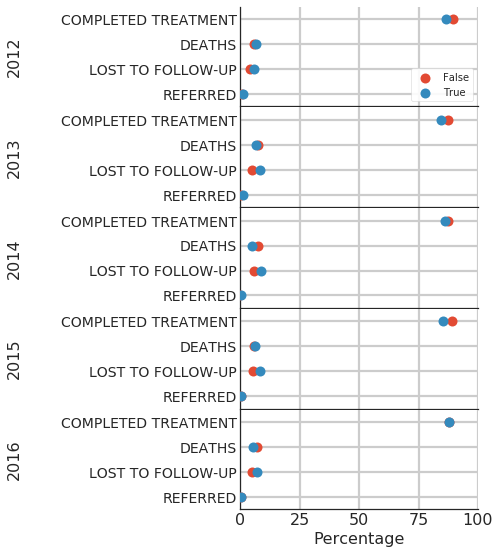

In [124]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[(datadf.col_name_.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH"])) &
       (datadf.deptocode!=0)].assign(Priority = lambda x: x.deptocode.isin(priority_deptos)).\
    groupby(["year", "Priority", "row_name_B"]).value.sum().unstack(2)
temp["total"] = temp.sum(axis=1)
print(temp)
temp = temp.fillna(0)
temp = \
    (np.round(temp.divide(temp["total"] , axis="rows")*100, decimals=1))
print(temp)
temp = temp.stack().reset_index()[lambda x: x["row_name_B"] != "total"]
temp.columns = ["Year", "Priority departments", "Outcome", "Percentage"]

temp["OutcomeB"] = temp.Outcome

grid = sb.FacetGrid(temp, row = "Year", hue = "Priority departments", aspect=4.5, size=1.5)
grid.map(sb.stripplot, "Percentage", "Outcome",  size=10) 
for ax in grid.axes: 
    ax[0].set_ylabel(ax[0].get_title()[-4:]+"\n\n")
    ax[0].set_title('')
    ax[0].grid(b = True, which="both", axis = "both", )
    ax[0].set_xlim(0,100)
hs,ls = grid.axes[0][0].get_legend_handles_labels()
grid.axes[0][0].legend([hs[0],hs[-1]], [ls[0],ls[-1]])
grid.fig.tight_layout(pad=0.0, h_pad=0.1, w_pad=0.1, rect=(0,0,1,1) )

row_name_      CURADOS  FRACASO_TERAPEUTICO  TRATAMIENTOS COMPLETOS   total
year Priority                                                              
2012 False       814.0                 13.0                   674.0  1501.0
     True       1024.0                 25.0                   518.0  1567.0
2013 False       773.0                 14.0                   605.0  1392.0
     True       1013.0                 22.0                   411.0  1446.0
2014 False       763.0                  7.0                   543.0  1313.0
     True        969.0                 25.0                   359.0  1353.0
2015 False       755.0                 16.0                   570.0  1341.0
     True       1076.0                 16.0                   423.0  1515.0
2016 False       828.0                 15.0                   407.0  1250.0
     True        989.0                 21.0                   481.0  1491.0
row_name_      CURED  TREATMENT FAILURE  PRESUMED CURED  total
year Priority            

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


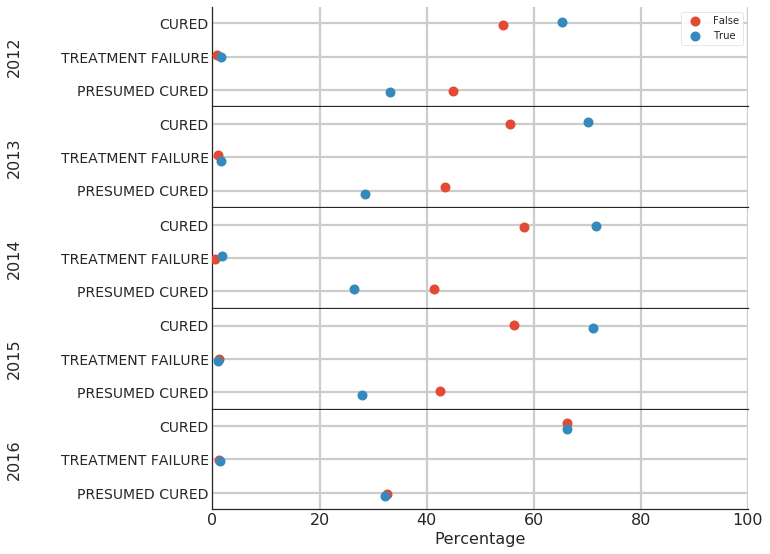

In [123]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[(datadf.col_name_.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH"])) &
       (datadf.deptocode!=0) & (datadf.row_name_B.isin(["COMPLETED TREATMENT"]))].\
    assign(Priority = lambda x: x.deptocode.isin(priority_deptos)).\
    groupby(["year", "Priority", "row_name_"]).value.sum().unstack(2)
temp["total"] = temp.sum(axis=1)
temp = temp.fillna(0)
print(temp)
temp = \
    (np.round(temp.divide(temp["total"] , axis="rows")*100, decimals=1))
temp.columns = pd.Series(["CURED", "TREATMENT FAILURE", "PRESUMED CURED", "total"], name="row_name_")
print(temp)
temp = temp.stack().reset_index()[lambda x: x["row_name_"] != "total"]
temp.columns = ["Year", "Prioritized Department", "Outcome", "Percentage"]

temp["OutcomeB"] = temp.Outcome

grid = sb.FacetGrid(temp, row = "Year", hue="Prioritized Department", aspect=7, size=1.5)
grid.map(sb.stripplot, "Percentage", "Outcome", size=10, jitter = True) 
for ax in grid.axes: 
    ax[0].set_ylabel(ax[0].get_title()[-4:]+"\n\n")
    ax[0].set_title('')
    ax[0].grid(b = True, which="both", axis = "both", )
    ax[0].set_xlim(0,100)
hs,ls = grid.axes[0][0].get_legend_handles_labels()
grid.axes[0][0].legend([hs[0],hs[-1]], [ls[0],ls[-1]])
grid.fig.tight_layout(pad=0.0, h_pad=0.1, w_pad=0.1, rect=(0,0,1,1) )

row_name_  CURADOS  FRACASO_TERAPEUTICO  TRATAMIENTOS COMPLETOS   total
year                                                                   
2012        1838.0                 38.0                  1192.0  3068.0
2013        1786.0                 36.0                  1016.0  2838.0
2014        1732.0                 32.0                   902.0  2666.0
2015        1831.0                 32.0                   993.0  2856.0
2016        1817.0                 36.0                   888.0  2741.0
row_name_  CURED  TREATMENT FAILURE  PRESUMED CURED  total
year                                                      
2012        59.9                1.2            38.9  100.0
2013        62.9                1.3            35.8  100.0
2014        65.0                1.2            33.8  100.0
2015        64.1                1.1            34.8  100.0
2016        66.3                1.3            32.4  100.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


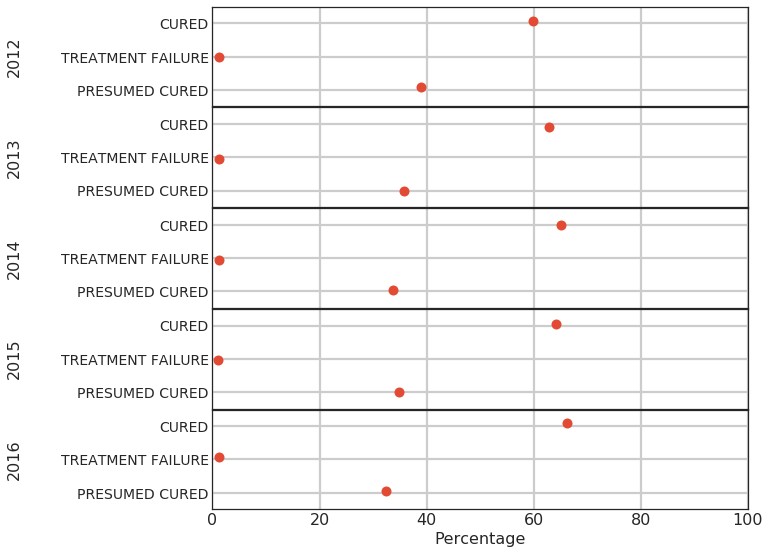

In [138]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[(datadf.col_name_.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH"])) &
       (datadf.deptocode!=0) & (datadf.row_name_B.isin(["COMPLETED TREATMENT"]))].\
    assign(Priority = lambda x: x.deptocode.isin(priority_deptos)).\
    groupby(["year", "row_name_"]).value.sum().unstack(1)
temp["total"] = temp.sum(axis=1)
temp = temp.fillna(0)
print(temp)
temp = \
    (np.round(temp.divide(temp["total"] , axis="rows")*100, decimals=1))
temp.columns = pd.Series(["CURED", "TREATMENT FAILURE", "PRESUMED CURED", "total"], name="row_name_")
print(temp)
temp = temp.stack().reset_index()[lambda x: x["row_name_"] != "total"]
temp.columns = ["Year", "Outcome", "Percentage"]

temp["OutcomeB"] = temp.Outcome

grid = sb.FacetGrid(temp, row = "Year", aspect=7, size=1.5)
grid.map(sb.stripplot, "Percentage", "Outcome", size=10, jitter = True) 
for ax in grid.axes: 
    ax[0].set_ylabel(ax[0].get_title()[-4:]+"\n\n")
    ax[0].set_title('')
    ax[0].grid(b = True, which="both", axis = "both", )
    ax[0].spines['top'].set_visible(True)
    ax[0].spines['right'].set_visible(True)
    ax[0].set_xlim(0,100)
grid.fig.tight_layout(pad=0.0, h_pad=0.1, w_pad=0.1, rect=(0,0,1,1) )

row_name_B  COMPLETED TREATMENT  DEATHS  LOST TO FOLLOW-UP  REFERRED   total
year                                                                        
2012                     3068.0   220.0              170.0      28.0  3486.0
2013                     2838.0   232.0              218.0      22.0  3310.0
2014                     2666.0   187.0              220.0       2.0  3075.0
2015                     2856.0   193.0              226.0       8.0  3283.0
2016                     2741.0   192.0              186.0      11.0  3130.0
row_name_B  COMPLETED TREATMENT  DEATHS  LOST TO FOLLOW-UP  REFERRED  total
year                                                                       
2012                       88.0     6.3                4.9       0.8  100.0
2013                       85.7     7.0                6.6       0.7  100.0
2014                       86.7     6.1                7.2       0.1  100.0
2015                       87.0     5.9                6.9       0.2  100.0
2016 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


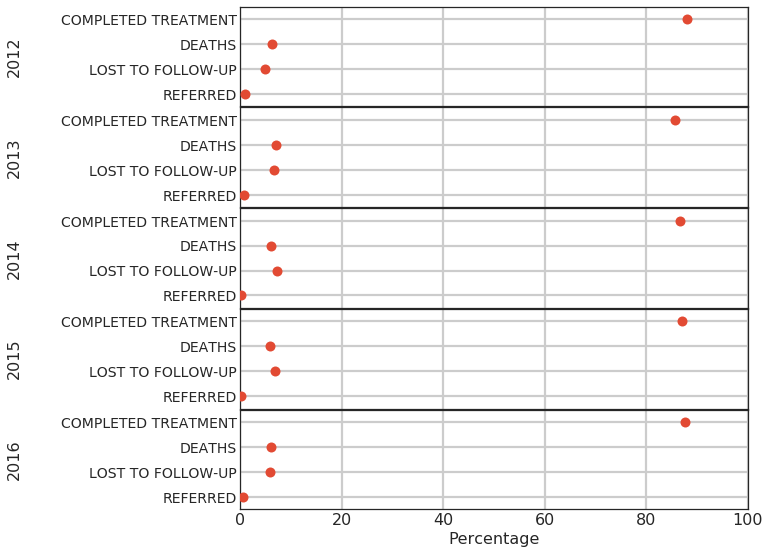

In [137]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[(datadf.col_name_.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH"])) &
       (datadf.deptocode!=0)].assign(Priority = lambda x: x.deptocode.isin(priority_deptos)).\
    groupby(["year", "row_name_B"]).value.sum().unstack(1)
temp["total"] = temp.sum(axis=1)
print(temp)
temp = temp.fillna(0)
temp = \
    (np.round(temp.divide(temp["total"] , axis="rows")*100, decimals=1))
print(temp)
temp = temp.stack().reset_index()[lambda x: x["row_name_B"] != "total"]
temp.columns = ["Year", "Outcome", "Percentage"]

temp["OutcomeB"] = temp.Outcome

grid = sb.FacetGrid(temp, row = "Year", aspect=7, size=1.5)
grid.map(sb.stripplot, "Percentage", "Outcome",  size=10) 
for ax in grid.axes: 
    ax[0].set_ylabel(ax[0].get_title()[-4:]+"\n\n")
    ax[0].set_title('')
    ax[0].grid(b = True, which="both", axis = "both", )
    ax[0].spines['top'].set_visible(True)
    ax[0].spines['right'].set_visible(True)
    ax[0].set_xlim(0,100)
grid.fig.tight_layout(pad=0.0, h_pad=0.1, w_pad=0.1, rect=(0,0,1,1))

In [133]:
x = ax[0]

In [135]:
g = x.get_

In [ ]:
g.